In [1]:
import numpy as np
import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/redM_Buzzard/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param


In [16]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn
import pickle

##TODO: Read fullrun .data file. 

filename = buzzdir +'redM_halos_fullmatchingparams_matchingv1.3_Buzzardv1.6.data'
infile = open(filename,'rb')
redM_data = pickle.load(infile)
infile.close()

print "Number of halos in the full catalog is ", len(redM_data)
print redM_data.dtype

#Apply mass cut
masscut = np.where(redM_data.M200B > 5e13)
redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_data)

Number of halos in the full catalog is  13628
(numpy.record, [('GALAXY_ID', '<i8'), ('HALOID', '<i8'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), (

In [31]:
##Shorthand name for relevant halo/redM parameters
richness = redM_data.LAMBDA_CHISQ
halos_M  = redM_data.M200B
halos_ID = redM_data.HALOID
q = redM_data.q
s = redM_data.s
cos_i = redM_data.cosi

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.699187097308249 15.53186194909581


In [32]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind = halo_bin_stat(cos_i, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q))]

Maximum richness after cuts is  303.0442810058594


In [40]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind[i]])

[35.35992093 33.72219524 33.96534815 ... 32.91594925 31.79990094
 32.05566413]


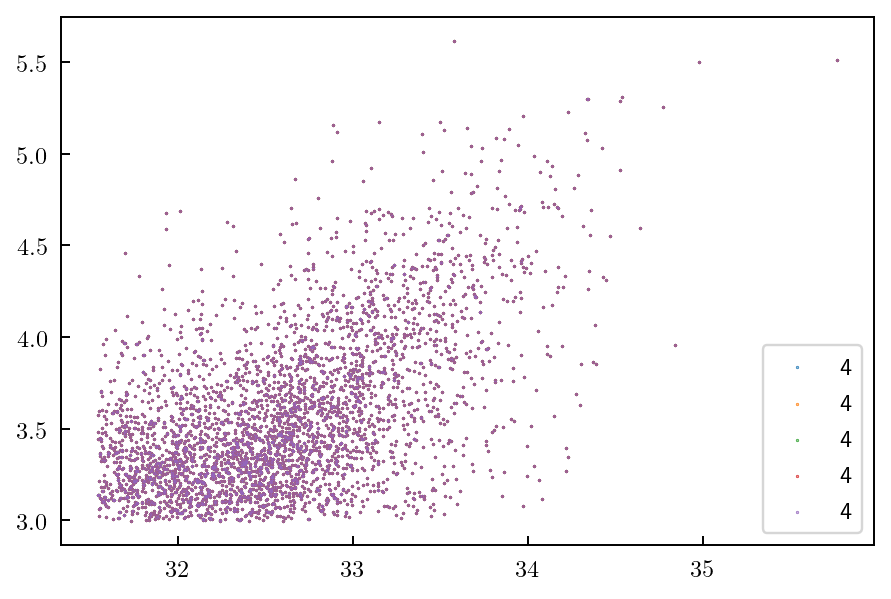

In [55]:
print lnM200b_binned[0]
for i in range(5):
    i=4
    plt.scatter(lnM200b_binned[i], lnl_binned[i], s=0.1, label=i)
plt.legend()
plt.show()

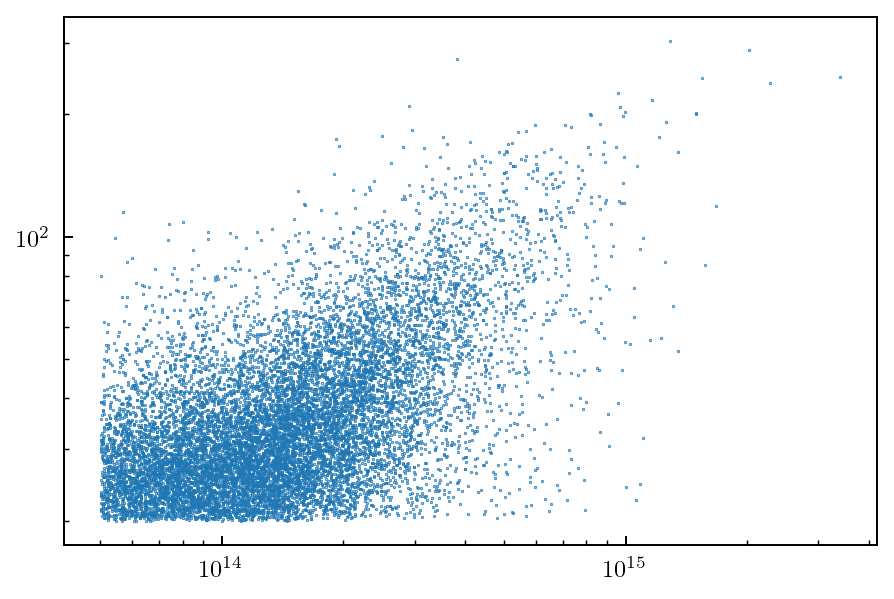

In [17]:
#Test that the 1 parameter model would fit this curve nicely. 
# Todo: Add inset to show small differences in trend. 
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))
             
#for all data points    
lnA_cosi_maxL = lnA_post_model3[-1,1]; B_cosi_maxL = B_post_model2[0,1]; sig0_cosi_maxL = sig0_post_model2[0,1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), \
            label='Combined', linewidth=2)
axs.axhline(5, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((4,600))
axs.set_xlim((4e13,2e15))

#Add an inset to show difference between lines
a = plt.axes([0.62, 0.2, .3, .3])
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', alpha=1)
plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), label='Combined', linewidth=2)
#plt.plot(halos_M, richness, 'k.', markersize=2)
plt.yscale('log'); plt.xscale('log')
plt.xlim((2.2e14, 3e14)); plt.ylim((47,60))   
plt.xticks((2.2e14, 3e14), (r'$2.2 \times 10^{14}$', r'$3 \times 10^{14}$'))
#plt.yticks([])

#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')

plt.show()

Fraction of redshift cut is 0.4912087912087912
number after z cut is  6258
After mass cut number of halos is  12740


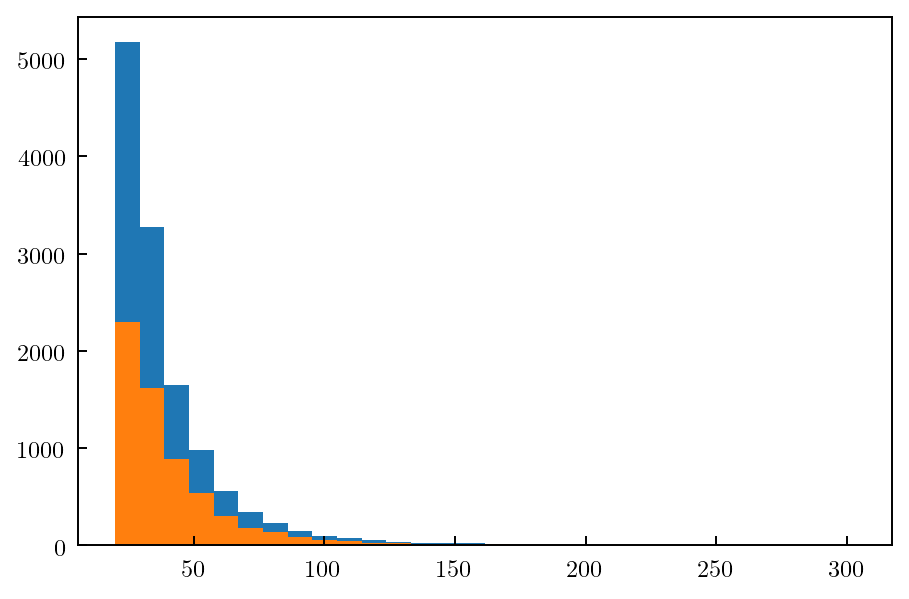

In [30]:
z_cut = np.where(redM_data.Z > 0.52)[0]
print "Fraction of redshift cut is", np.true_divide(len(z_cut), len(redM_data))
print "number after z cut is ", len(z_cut)
print "After mass cut number of halos is ", len(redM_data)

plt.hist(redM_data.LAMBDA_CHISQ, bins=30)
plt.hist(redM_data[z_cut].LAMBDA_CHISQ, bins=30)
plt.show()